In [62]:
from __future__ import annotations
import numpy as np
import pandas as pd
from typing import Optional, Tuple, Union, Sequence, List
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
import inspect

class BaseSAAdapter(ABC):
    @abstractmethod
    def fit(self, X, y, time_col: str = "time", event_col: str = "event"): ...
    @abstractmethod
    def predict_survival_function(self, X, times: Optional[Sequence[float]] = None): ...
    @abstractmethod
    def predict_hazard_function(self, X, times: Optional[Sequence[float]] = None): ...
    @abstractmethod
    def predict_expected_time(self, X, times=None): ...
    @abstractmethod
    def predict_time(self,X): ...
    @abstractmethod
    def predict_proba(self, X): ...
    
    def timeWrap(self, y, time_col="time", event_col="event"):
        if isinstance(y, tuple) and len(y) == 2:
            t, e = y
            return np.asarray(t, float), np.asarray(e, bool)
        if isinstance(y, pd.DataFrame):
            return y[time_col].to_numpy(dtype=float), y[event_col].to_numpy(dtype=bool)
        if isinstance(y, dict):
            return np.asarray(y[time_col], float), np.asarray(y[event_col], bool)
        if isinstance(y, np.ndarray) and y.dtype.names:
            names = list(y.dtype.names)
            ev = next((n for n in names if n.lower().startswith(("event", "status"))), names[0])
            tm = next((n for n in names if n.lower().startswith(("time", "duration"))), names[-1])
            return y[tm].astype(float), y[ev].astype(bool)
        raise ValueError("Unsupported y format")
    
    @staticmethod
    def _has(obj, name): return hasattr(obj, name)

    def _get_proba(self, model, X) -> np.ndarray:
        if self._has(model, "predict_proba"):
            proba = model.predict_proba(X)
            if proba.ndim == 2 and proba.shape[1] >= 2:
                return proba[:, 1]
            return np.clip(np.ravel(proba), 0.0, 1.0)
        if self._has(model, "decision_function"):
            z = np.asarray(model.decision_function(X), float).ravel()
            return 1.0 / (1.0 + np.exp(-z))
        if self._has(model, "predict"):
            yhat = np.asarray(model.predict(X))
            if set(np.unique(yhat)).issubset({0, 1, False, True}):
                return yhat.astype(float)
            ymin, ymax = float(np.min(yhat)), float(np.max(yhat))
            if ymax > ymin:
                return np.clip((yhat - ymin) / (ymax - ymin), 0.0, 1.0)
            return np.zeros_like(yhat, dtype=float)
        n = len(X) if hasattr(X, "__len__") else 1
        return np.full(n, 0.5, float)


class ClassifWrapSA(BaseSAAdapter):
    def __init__(self, model, times: int = 128, start_at_zero: bool = True):
        self.model = model
        self.times = times
        self.start_at_zero = start_at_zero
        self._bounds: Optional[Tuple[float, float]] = None
    def fit(self, X, y, time_col: str = "time", event_col: str = "event"):
        t, e = self.timeWrap(y, time_col, event_col)
        left = float(np.min(t))
        right = float(np.max(t))
        if not np.isfinite(left) or not np.isfinite(right) or left >= right:
            left = 0.0
            right = 1.0
        self._bounds = (left, right)
        self.model.fit(X, e.astype(int))
        return self
    def predict_proba(self, X):
        proba = self._get_proba(self.model, X)
        if proba.ndim == 1:
            proba = np.column_stack([1 - proba, proba])
        return proba
    def predict_survival_function(self, X, times = None):
        assert self._bounds is not None, "Call fit() first"
        if times is not None:
            t = np.asarray(times, float)
        else:
            left, right = self._bounds
            start = 0.0 if self.start_at_zero else left
            t = np.linspace(start, right, self.times) #разбивает на равномерную сетку
        p = self._get_proba(self.model, X)
        S = np.tile((1.0-p)[:, None], (1,t.size)) #матрица выживаемости dim(p)*t.size
        return S, t
    def predict_hazard_function(self, X, times=None):
        S, t = self.predict_survival_function(X, times)
        eps = 1e-12
        H = -np.log(np.clip(S, eps, 1.0))   # кумулятивная hazard, константна по t
        return H, t
    def predict_expected_time(self, X, times=None):
        S, t = self.predict_survival_function(X, times)
        return np.trapz(S, t, axis=1)
    def predict_time(self, X):
        n = len(X) if hasattr(X, "__len__") else self.predict_proba(X).shape[0]
        return np.full(n, np.nan, float)
class RegrWrapSA(BaseSAAdapter):
    def __init__(self, model, times: int = 128, start_at_zero: bool = True):
        self.model = model
        self.times = times
        self.start_at_zero = start_at_zero
        self._bounds: Optional[Tuple[float, float]] = None
    def fit(self, X, y, time_col: str = "time", event_col: str = "event"):
        t, _ = self.timeWrap(y, time_col, event_col)
        left = float(np.min(t))
        right = float(np.max(t))
        if not np.isfinite(left) or not np.isfinite(right) or left >= right:
            left = 0.0
            right = 1.0
        self._bounds = (left, right)
        self.model.fit(X, t.astype(float))
        return self
    def predict_time(self, X):
        return np.asarray(self.model.predict(X), float)
    def predict_survival_function(self, X, times = None):
        assert self._bounds is not None, "Call fit() first"
        if times is not None:
            t = np.asarray(times, float)
        else:
            left, right = self._bounds
            start = 0.0 if self.start_at_zero else left
            t = np.linspace(start, right, self.times) #разбивает на равномерную сетку
        T = self.predict_time(X)[:, None]
        S = (t[None, :] < T).astype(float)
        return S, t
    def predict_hazard_function(self, X, times = None):
        S, t = self.predict_survival_function(X, times)
        eps = 1e-12
        H = -np.log(np.clip(S, eps, 1.0))  # кумулятивная hazard
        return H, t
    def predict_expected_time(self, X, times=None):
        S, t = self.predict_survival_function(X, times)
        return np.trapz(S, t, axis=1)
    def predict_proba(self, X):
        S, _ = self.predict_survival_function(X)
        p = 1.0 - S[:, -1]
        return np.column_stack([1.0 - p, p])
class SAWrapSA(BaseSAAdapter):
    def __init__(self, model, times: int = 128, start_at_zero: bool = True):
        self.model = model
        self.times = times
        self.start_at_zero = start_at_zero
        self._bounds: Optional[Tuple[float, float]] = None
        self._kind = model.__class__.__module__
    @staticmethod
    def _make_structured_y(t, e):
        return np.array(list(zip(e.astype(bool), t.astype(float))), dtype=[('event','?'),('time','<f8')])
    
    def fit(self, X, y, time_col: str = "time", event_col: str = "event"):
        t, e = self.timeWrap(y, time_col, event_col)
        left = float(np.min(t))
        right = float(np.max(t))
        if not np.isfinite(left) or not np.isfinite(right) or left >= right:
            left = 0.0
            right = 1.0
        self._bounds = (left, right)
        if "lifelines" in self._kind:
            fit_sig = inspect.signature(self.model.fit)
            params = fit_sig.parameters
            if "duration_col" in params: #двумерные, например CoxPHFitter
                df = pd.DataFrame(X if isinstance(X, pd.DataFrame) else np.asarray(X)).copy()
                df[time_col] = t
                df[event_col] = e.astype(int)
                self.model.fit(df, duration_col=time_col, event_col=event_col)
            else: #одномерные, например NelsonAalenFitter
                if "durations" in params:
                    self.model.fit(durations=t, event_observed=e.astype(int))
                else:
                    self.model.fit(t, e.astype(int))
        elif self._kind.startswith("sksurv.") or "sksurv" in self._kind:
            self.model.fit(X, self._make_structured_y(t, e))
        elif "survivors" in self._kind:
            self.model.fit(X, y)
        else:
            self.model.fit(X, y)
        return self
    def predict_survival_function(self, X, times = None):
        assert self._bounds is not None, "Call fit() first"
        if times is not None:
            t = np.asarray(times, float)
        else:
            left, right = self._bounds
            start = 0.0 if self.start_at_zero else left
            t = np.linspace(start, right, self.times) #разбивает на равномерную сетку
        if "lifelines" in self._kind:
            n = len(X) if hasattr(X, "__len__") else 1
            if hasattr(self.model, "predict_survival_function"): #двумерны
                df = X if isinstance(X, pd.DataFrame) else pd.DataFrame(X)
                sf = self.model.predict_survival_function(df)
                if isinstance(sf, list):
                    S = np.vstack([np.interp(t, s.index.values.astype(float), np.asarray(s).astype(float)) for s in sf])
                else:   #одномерные
                    idx = sf.index.values.astype(float)
                    S = np.vstack([np.interp(t, idx, sf.iloc[:, i].values.astype(float)) for i in range(sf.shape[1])])
                return S, t
            #одномерные 
            if hasattr(self.model, "survival_function_at_times"):
                s = self.model.survival_function_at_times(t)
                s_vals = np.asarray(s).astype(float).ravel()
            elif hasattr(self.model, "cumulative_hazard_at_times"):
                H = self.model.cumulative_hazard_at_times(t)
                H_vals = np.asarray(H).astype(float).ravel()
                s_vals = np.exp(-H_vals)
            else:
                raise RuntimeError("lifelines univariate model without at_times methods")
            S = np.tile(s_vals[None, :], (n, 1))
            return S, t
        elif self._kind.startswith("sksurv.") or "sksurv" in self._kind:
            s = self.model.predict_survival_function(X)
            S = np.vstack([sf(t) for sf in s])
            return S, t
        elif "survivors" in self._kind:
            if times is not None:
                t = np.asarray(times, float)
            else:
                left, right = self._bounds
                start = 0.0 if self.start_at_zero else left
                t = np.linspace(start, right, self.times)
            S = np.asarray(self.model.predict_at_times(X, t, mode="surv"), float)
            if S.ndim == 1:
                S = S[None, :]
            elif S.shape[1] != t.shape[0] and S.shape[0] == t.shape[0]:
                S = S.T
            return S, t
        raise RuntimeError("Model does not provide survival predictions")
        
    def predict_hazard_function(self, X, times = None):
        assert self._bounds is not None, "Call fit() first"
        if "lifelines" in self._kind:
            if times is not None:
                t = np.asarray(times, float)
            else:
                left, right = self._bounds
                start = 0.0 if self.start_at_zero else left
                t = np.linspace(start, right, self.times) #разбивает на равномерную сетку
            n = len(X) if hasattr(X, "__len__") else 1
            if hasattr(self.model, "predict_cumulative_hazard"): #двумерные
                df = X if isinstance(X, pd.DataFrame) else pd.DataFrame(X)
                ch = self.model.predict_cumulative_hazard(df)
                if isinstance(ch, list):
                    H = np.vstack([np.interp(t, h.index.values.astype(float), np.asarray(h).astype(float)) for h in ch])
                else:
                    idx = ch.index.values.astype(float)
                    H = np.vstack([np.interp(t, idx, ch.iloc[:, i].values.astype(float)) for i in range(ch.shape[1])])
                return H, t
            if hasattr(self.model, "cumulative_hazard_at_times"): #одномерные
                try:
                    H_single = self.model.cumulative_hazard_at_times(t)
                    H_vals = np.asarray(H_single).astype(float).ravel()
                    H = np.tile(H_vals[None, :], (n, 1))
                    return H, t
                except NotImplementedError:
                    pass
            if hasattr(self.model, "survival_function_at_times"):
                try:
                    s = self.model.survival_function_at_times(t)
                    s_vals = np.asarray(s).astype(float).ravel()
                    eps = 1e-12
                    H_vals = -np.log(np.clip(s_vals, eps, 1.0))
                    H = np.tile(H_vals[None, :], (n, 1))
                    return H, t
                except NotImplementedError:
                    pass
            S, t = self.predict_survival_function(X, t)
            eps = 1e-12
            H = -np.log(np.clip(S, eps, 1.0))
            return H, t
        if "survivors" in self._kind:
            if times is not None:
                t = np.asarray(times, float)
            else:
                left, right = self._bounds
                start = 0.0 if self.start_at_zero else left
                t = np.linspace(start, right, self.times)
            H = np.asarray(self.model.predict_at_times(X, t, mode="hazard"), float)
            if H.ndim == 1:
                H = H[None, :]
            elif H.shape[1] != t.shape[0] and H.shape[0] == t.shape[0]:
                H = H.T
            return H, t

        S, t = self.predict_survival_function(X, times) #для всех других моделей
        eps = 1e-12
        H = -np.log(np.clip(S, eps, 1.0))
        return H, t
    def predict_expected_time(self, X, times=None):
        S, t = self.predict_survival_function(X, times)
        return np.trapz(S, t, axis=1)
    def predict_time(self, X):
        S, t = self.predict_survival_function(X)
        med = np.full(S.shape[0], np.nan, float)
        for i, row in enumerate(S):
            j = np.argmax(row <= 0.5)
            if row[j] <= 0.5:
                med[i] = t[j]
        return med
    def predict_proba(self, X):
        S, _ = self.predict_survival_function(X)
        p = 1.0 - S[:, -1]
        return np.column_stack([1.0 - p, p])

def plot_many(models, X, sample: int = 0, times: Optional[Sequence[float]] = None, title="Survival curves comparison", mode: str = "survival"):
    if times is not None:
        t_common = np.asarray(times, float)
    else:
        t_max = 1.0
        for m in models:
            if m._bounds is not None:
                t_max = max(t_max, m._bounds[1])
        t_common = np.linspace(0.0, t_max, 128)
    X_i = X.iloc[[sample]] if isinstance(X, pd.DataFrame) else np.asarray(X)[[sample], :]
    plt.figure(figsize=(7, 5))
    for m in models:
        name = type(m.model).__name__
        if mode.lower().startswith("h"):
            S, _ = m.predict_hazard_function(X_i, t_common)
            ylabel = "Hazard H(t)"
        else:
            S, _ = m.predict_survival_function(X_i, t_common)
            ylabel = "Survival S(t)"
        plt.plot(t_common, S[0], label=name)
    plt.xlabel("Time")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()
import numpy as np

def get_bins(y, n_bins: int = 128, start_at_zero: bool = True):
    if not (isinstance(y, np.ndarray) and y.dtype.names):
        raise TypeError("get_bins ожидает structured array с именованными полями")

    names = list(y.dtype.names)
    time_field = next(
        (n for n in names if n.lower().startswith(("time", "duration"))),
        names[-1]  # если не нашли, берём последнее поле
    )

    t = np.asarray(y[time_field], float)
    t = t[np.isfinite(t)]
    if t.size == 0:
        raise ValueError("get_bins: нет корректных значений времени (всё NaN/inf)")

    if start_at_zero:
        start = 0.0
    else:
        start = float(np.min(t))

    right = float(np.max(t))
    if right <= start:
        right = start + 1.0

    return np.linspace(start, right, int(n_bins))





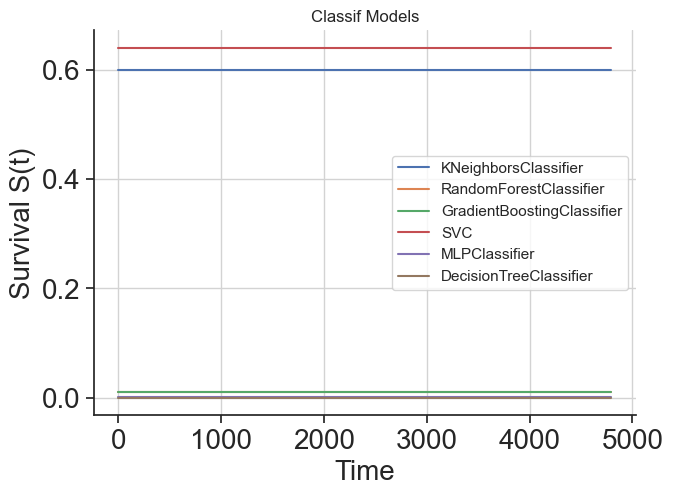

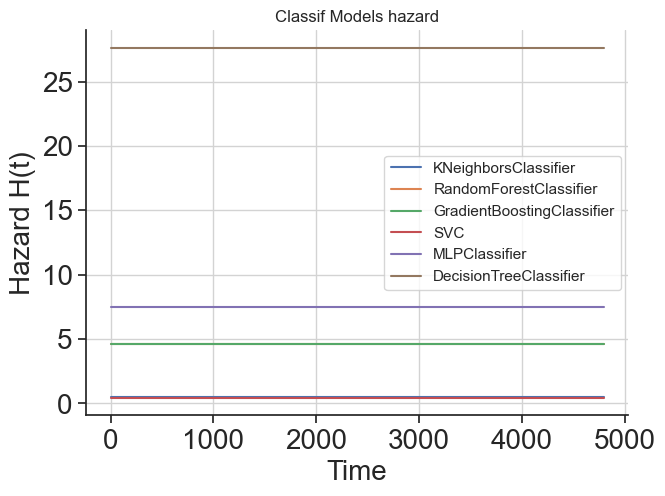

In [63]:
# scikit-learn — classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
# scikit-learn — regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
# lifelines — survival analysis
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines import (
    WeibullAFTFitter,
    LogNormalAFTFitter,
    LogLogisticAFTFitter
)
# scikit-survival — survival analysis
from sksurv.ensemble import RandomSurvivalForest, GradientBoostingSurvivalAnalysis
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis
from sksurv.linear_model import CoxnetSurvivalAnalysis, CoxPHSurvivalAnalysis
from lifelines import CoxPHFitter, ExponentialFitter, WeibullFitter, BreslowFlemingHarringtonFitter, LogLogisticFitter
#survivors
from survivors.ensemble import ParallelBootstrapCRAID, BoostingCRAID
import survivors.datasets as ds
from survivors.tree import CRAID

X, y, features, categ, sch_nan = ds.load_pbc_dataset()
X = X.fillna(0)
m1 = ClassifWrapSA(KNeighborsClassifier()).fit(X, y)
m2 = ClassifWrapSA(RandomForestClassifier()).fit(X, y)
m3 = ClassifWrapSA(GradientBoostingClassifier()).fit(X, y)
m4 = ClassifWrapSA(SVC()).fit(X, y)
m5 = ClassifWrapSA(MLPClassifier()).fit(X, y)
m6 = ClassifWrapSA(DecisionTreeClassifier()).fit(X, y)



plot_many([m1, m2, m3, m4, m5, m6], X, sample=0, title="Classif Models")
plot_many([m1, m2, m3, m4, m5, m6], X, sample=0, title="Classif Models hazard", mode = "hazard")

d:\Users\DimonZhi\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


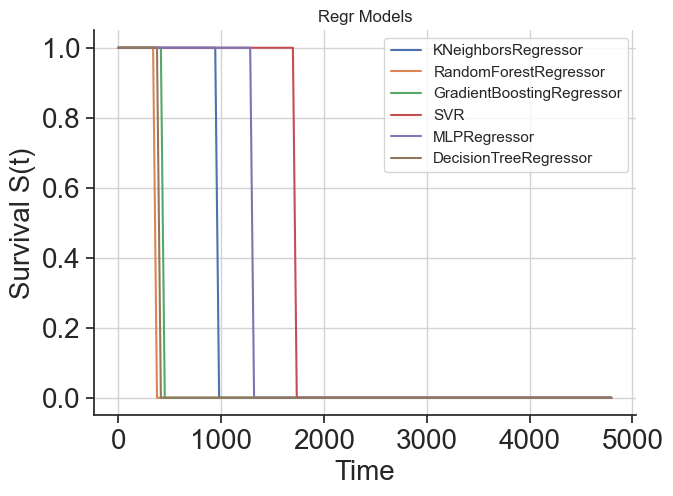

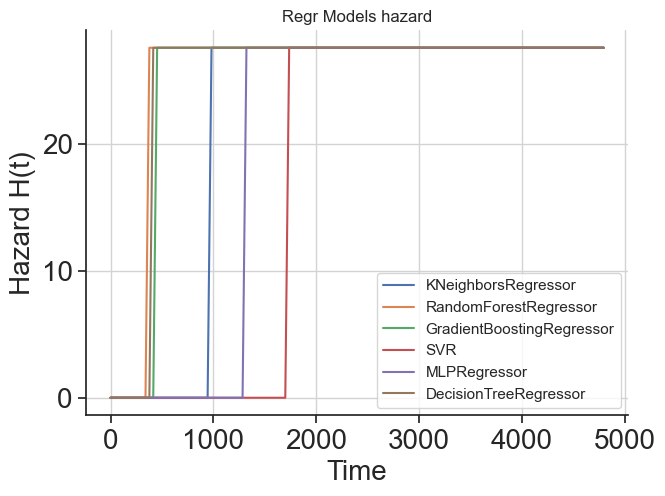

In [64]:
m7 = RegrWrapSA(KNeighborsRegressor()).fit(X,y)
m8 = RegrWrapSA(RandomForestRegressor()).fit(X,y)
m9 = RegrWrapSA(GradientBoostingRegressor()).fit(X,y)
m10 = RegrWrapSA(SVR()).fit(X,y)
m11 = RegrWrapSA(MLPRegressor()).fit(X,y)
m12 = RegrWrapSA(DecisionTreeRegressor()).fit(X,y)
plot_many([m7, m8, m9, m10, m11, m12], X, sample=0, title="Regr Models")
plot_many([m7, m8, m9, m10, m11, m12], X, sample=0, title="Regr Models hazard", mode = "hazard")

fitted: 10 models.


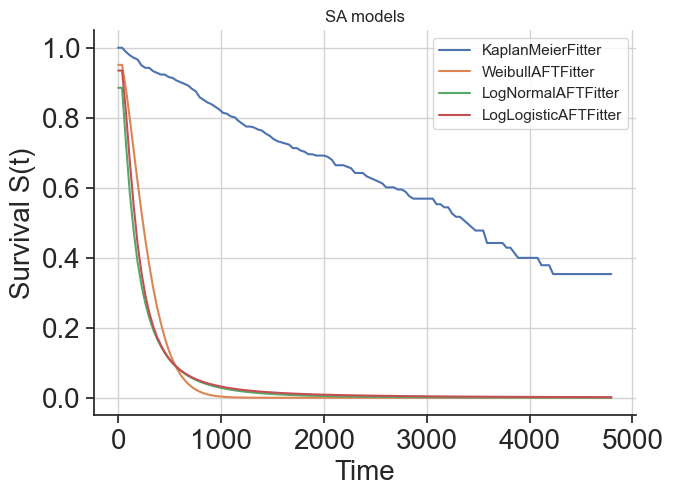

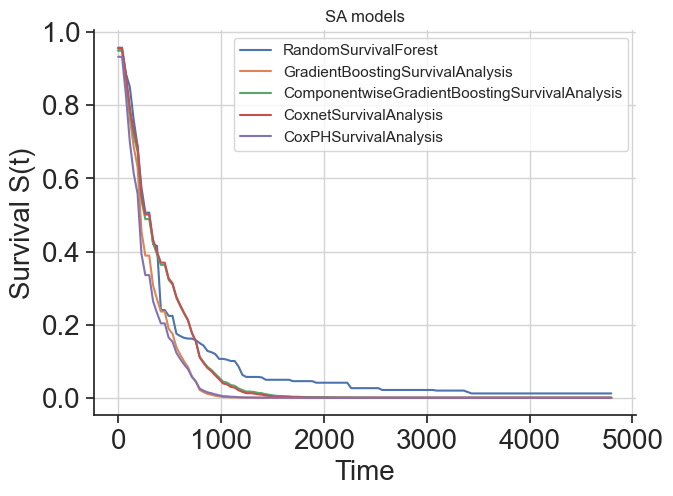

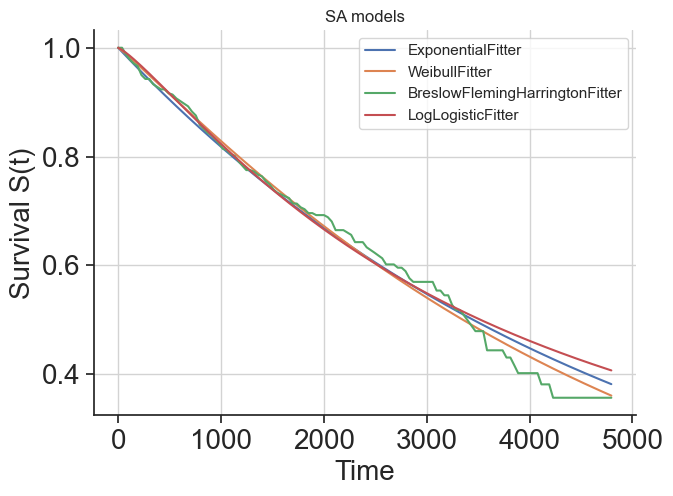

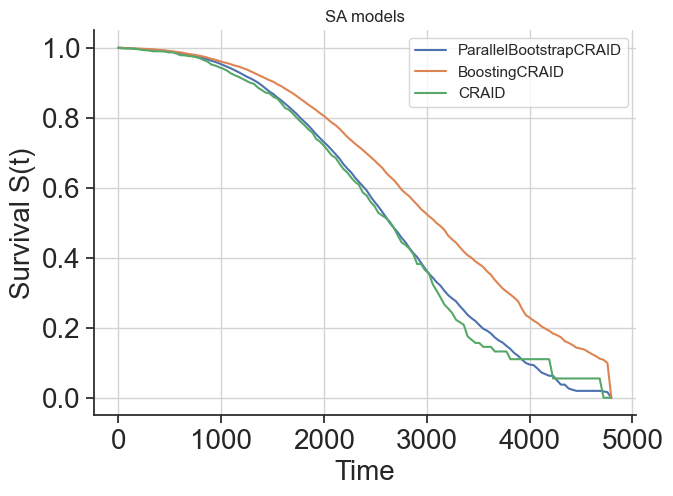

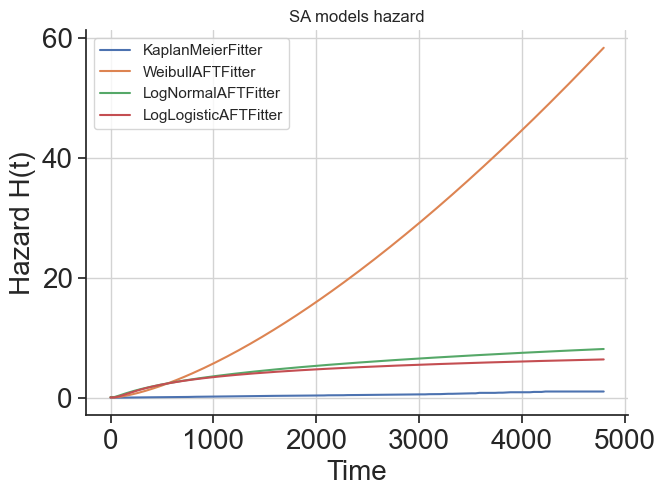

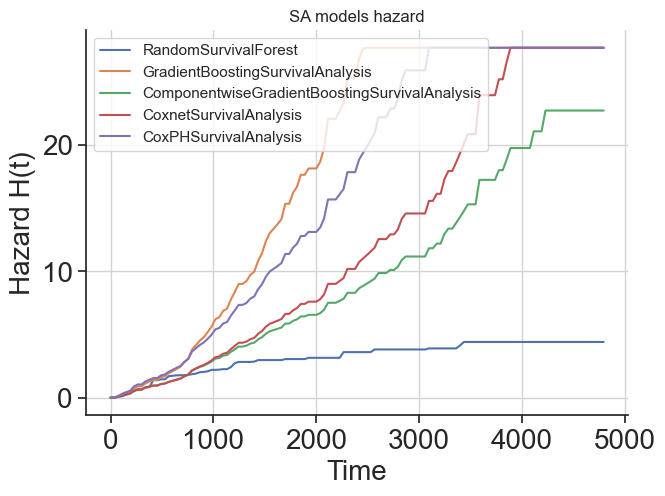

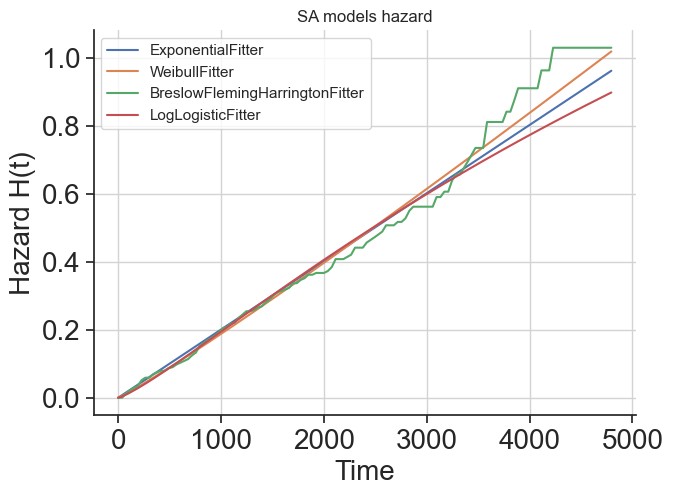

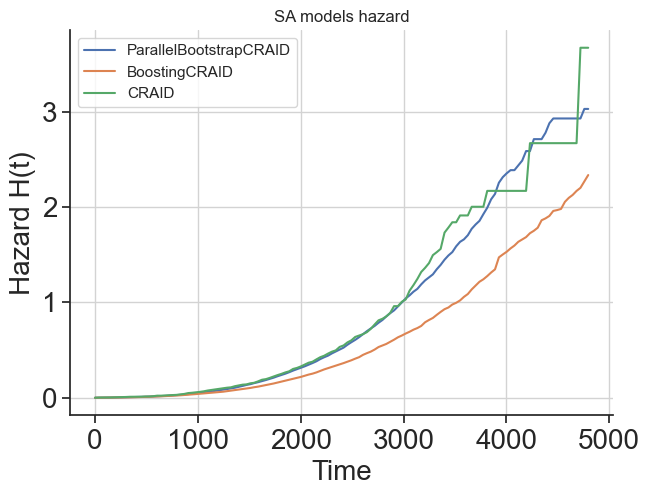

In [65]:
m13 = SAWrapSA(KaplanMeierFitter()).fit(X,y)
m14 = SAWrapSA(CoxPHFitter()).fit(X,y)
m15 = SAWrapSA(WeibullAFTFitter()).fit(X,y)
m16 = SAWrapSA(LogNormalAFTFitter()).fit(X,y)
m17 = SAWrapSA(LogLogisticAFTFitter()).fit(X,y)

m18 = SAWrapSA(RandomSurvivalForest()).fit(X,y)
m19 = SAWrapSA(GradientBoostingSurvivalAnalysis()).fit(X,y)
m20 = SAWrapSA(ComponentwiseGradientBoostingSurvivalAnalysis()).fit(X,y)
m21 = SAWrapSA(CoxnetSurvivalAnalysis(fit_baseline_model=True)).fit(X,y)
m22 = SAWrapSA(CoxPHSurvivalAnalysis()).fit(X,y)
m23 = SAWrapSA(ExponentialFitter()).fit(X,y)
m24 = SAWrapSA(WeibullFitter()).fit(X,y)
m25 = SAWrapSA(BreslowFlemingHarringtonFitter()).fit(X,y)
m26 = SAWrapSA(LogLogisticFitter()).fit(X,y)

m27 = SAWrapSA(ParallelBootstrapCRAID()).fit(X,y)
m28 = SAWrapSA(BoostingCRAID()).fit(X,y)
m29 = SAWrapSA(CRAID()).fit(X,y)

plot_many([m13, m15, m16, m17], X, sample = 0, title = "SA models")
plot_many([m18, m19, m20, m21, m22], X, sample = 0, title = "SA models")
plot_many([m23, m24, m25, m26], X, sample = 0, title = "SA models")
plot_many([m27, m28, m29], X, sample = 0, title = "SA models")

plot_many([m13, m15, m16, m17], X, sample = 0, title = "SA models hazard", mode = "hazard")
plot_many([m18, m19, m20, m21, m22], X, sample = 0, title = "SA models hazard", mode = "hazard")
plot_many([m23, m24, m25, m26], X, sample = 0, title = "SA models hazard", mode = "hazard")
plot_many([m27, m28, m29], X, sample = 0, title = "SA models hazard", mode = "hazard")

UnboundLocalError: cannot access local variable 'ylabel' where it is not associated with a value

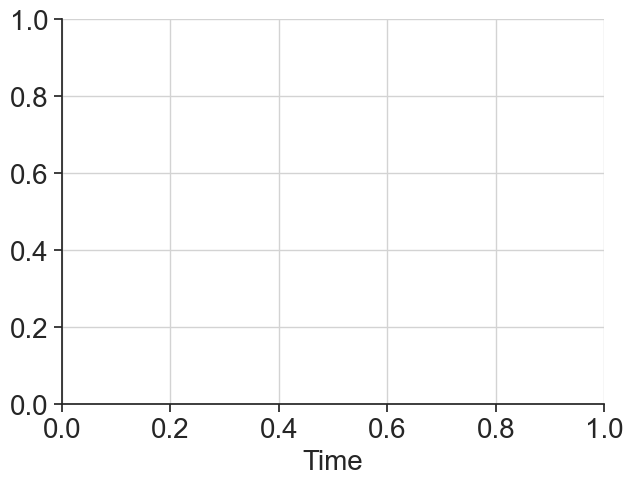

In [ ]:
X, y, features, categ, sch_nan = ds.load_pbc_dataset()
X = X.fillna(0)

cr = CRAID(criterion='wilcoxon', depth=2, min_samples_leaf=0.1,
           signif=0.05, categ=categ, leaf_model="base")

m1 = SAWrapSA(CoxPHFitter()).fit(X, y)
m2 = SAWrapSA(cr).fit(X, y)
m3 = SAWrapSA(ExponentialFitter()).fit(X, y)
m4 = SAWrapSA(WeibullFitter()).fit(X, y)
m5 = SAWrapSA(BreslowFlemingHarringtonFitter()).fit(X, y)
m6 = SAWrapSA(LogLogisticFitter()).fit(X, y)

plot_many([m1,m2,m3,m4,m5,m6], X, sample=0, title="Lifelines vs Survivors")

In [ ]:
from sklearn.model_selection import train_test_split
from metrics_sa import eval_survival_model, print_metrics
m1 = RegrWrapSA(RandomForestRegressor()).fit(X,y)

X_tr, X_tst, y_tr, y_tst = train_test_split(X, y, test_size=0.2, random_state=42)
bins = get_bins(y, 128)
#metrics = eval_survival_model(m1, X, y["time"], x)
#print_metrics(metrics, "RandomForestRegressor")
print_metrics(eval_survival_model(m1, X_tr, y_tr, X_tst, y_tst, bins), "RandomForestRegressor")

RandomForestRegressor
c_index     : 0.9313
ibs_remain  : 0.0695
auprc       : 0.8581


Text(0.5, 1.0, '(True, 2011.0)')

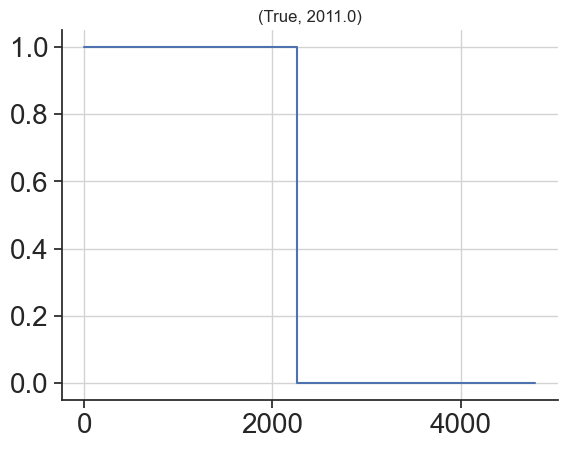

In [ ]:
pred_sf = m1.predict_survival_function(X_tst, bins)
plt.step(pred_sf[1], pred_sf[0][0])
plt.title(y_tst[0])

In [ ]:
from metrics_sa import eval_classification_model
event = y["cens"]
y_event = event.astype(int)
metrics = eval_classification_model(m1, X, y_event)
print_metrics(metrics, "CoxPHFitter")
metrics = eval_classification_model(m2, X, y_event)
print_metrics(metrics, "CRAID")
metrics = eval_classification_model(m3, X, y_event)
print_metrics(metrics, "ExponentialFitter")
metrics = eval_classification_model(m4, X, y_event)
print_metrics(metrics, "WeibullFitter")
metrics = eval_classification_model(m5, X, y_event)
print_metrics(metrics, "BreslowFlemingHarringtonFitter")
metrics = eval_classification_model(m6, X, y_event)
print_metrics(metrics, "LogLogisticFitter")

CoxPHFitter
accuracy    : 0.3852
f1          : 0.5561
roc_auc     : 0.5000
log_loss    : 22.1608
brier       : 0.6148
CRAID
accuracy    : 0.7416
f1          : 0.6516
roc_auc     : 0.7070
log_loss    : 3.7006
brier       : 0.2662
ExponentialFitter
accuracy    : 0.3852
f1          : 0.5561
roc_auc     : 0.5000
log_loss    : 0.7773
brier       : 0.2911
WeibullFitter
accuracy    : 0.3852
f1          : 0.5561
roc_auc     : 0.5000
log_loss    : 0.7993
brier       : 0.3014
BreslowFlemingHarringtonFitter
accuracy    : 0.3852
f1          : 0.5561
roc_auc     : 0.5000
log_loss    : 0.8037
brier       : 0.3034
LogLogisticFitter
accuracy    : 0.3852
f1          : 0.5561
roc_auc     : 0.5000
log_loss    : 0.7540
brier       : 0.2800


In [ ]:
from sklearn.model_selection import train_test_split
from metrics_sa import eval_survival_model, print_metrics

bins = get_bins(y_tr, n_bins=m1.times)
print(bins)


[   0.           35.61417323   71.22834646  106.84251969  142.45669291
  178.07086614  213.68503937  249.2992126   284.91338583  320.52755906
  356.14173228  391.75590551  427.37007874  462.98425197  498.5984252
  534.21259843  569.82677165  605.44094488  641.05511811  676.66929134
  712.28346457  747.8976378   783.51181102  819.12598425  854.74015748
  890.35433071  925.96850394  961.58267717  997.19685039 1032.81102362
 1068.42519685 1104.03937008 1139.65354331 1175.26771654 1210.88188976
 1246.49606299 1282.11023622 1317.72440945 1353.33858268 1388.95275591
 1424.56692913 1460.18110236 1495.79527559 1531.40944882 1567.02362205
 1602.63779528 1638.2519685  1673.86614173 1709.48031496 1745.09448819
 1780.70866142 1816.32283465 1851.93700787 1887.5511811  1923.16535433
 1958.77952756 1994.39370079 2030.00787402 2065.62204724 2101.23622047
 2136.8503937  2172.46456693 2208.07874016 2243.69291339 2279.30708661
 2314.92125984 2350.53543307 2386.1496063  2421.76377953 2457.37795276
 2492.9

In [ ]:
import survivors.constants as cnt
bins = cnt.get_bins(time=y[cnt.TIME_NAME], cens=y[cnt.CENS_NAME])
print(bins)

[  41   42   43 ... 4189 4190 4191]


In [ ]:
from metrics_sa import eval_survival_model, print_metrics
from sklearn.model_selection import train_test_split

X_tr, X_tst, y_tr, y_tst = train_test_split(X, y, test_size=0.2, random_state=42)

cr = CRAID(criterion='logrank', depth=15, min_samples_leaf=0.1,
           signif=0.05, categ=categ, leaf_model="base")

m_sa1 = SAWrapSA(CoxPHFitter(penalizer=0.01)).fit(X_tr, y_tr)
m_sa2 = SAWrapSA(cr).fit(X_tr, y_tr)
m_sa3 = SAWrapSA(ExponentialFitter()).fit(X_tr, y_tr)
m_sa4 = SAWrapSA(WeibullFitter()).fit(X_tr, y_tr)
m_sa5 = SAWrapSA(BreslowFlemingHarringtonFitter()).fit(X_tr, y_tr)
m_sa6 = SAWrapSA(LogLogisticFitter()).fit(X_tr, y_tr)
bins = get_bins(y_tr, n_bins=100)

print_metrics(eval_survival_model(m_sa1, X_tr, y_tr, X_tst, y_tst, bins), "CoxPHFitter")
print_metrics(eval_survival_model(m_sa2,  X_tr, y_tr, X_tst, y_tst, bins), "CRAID")
print_metrics(eval_survival_model(m_sa3, X_tr, y_tr, X_tst, y_tst, bins), "ExponentialFitter")
print_metrics(eval_survival_model(m_sa4,  X_tr, y_tr, X_tst, y_tst, bins), "WeibullFitter")
print_metrics(eval_survival_model(m_sa5, X_tr, y_tr, X_tst, y_tst, bins), "BreslowFlemingHarringtonFitter")
print_metrics(eval_survival_model(m_sa6,  X_tr, y_tr, X_tst, y_tst, bins), "LogLogisticFitter")

CoxPHFitter
c_index     : 0.6801
ibs_remain  : 0.1514
auprc       : 0.6609
CRAID
c_index     : 0.6906
ibs_remain  : 0.1180
auprc       : 0.6873
ExponentialFitter
c_index     : 0.5000
ibs_remain  : 0.2177
auprc       : 0.5595
WeibullFitter
c_index     : 0.5000
ibs_remain  : 0.2137
auprc       : 0.5733
BreslowFlemingHarringtonFitter
c_index     : 0.5000
ibs_remain  : 0.2118
auprc       : 0.5784
LogLogisticFitter
c_index     : 0.5000
ibs_remain  : 0.2184
auprc       : 0.5674


In [ ]:
from metrics_sa import eval_survival_model, print_metrics
from sklearn.model_selection import train_test_split

X_tr, X_tst, y_tr, y_tst = train_test_split(X, y, test_size=0.2)

m_sa1 = SAWrapSA(CoxPHFitter()).fit(X_tr, y_tr)
m_sa2 = SAWrapSA(cr).fit(X_tr, y_tr)
m_sa3 = SAWrapSA(ExponentialFitter()).fit(X_tr, y_tr)
m_sa4 = SAWrapSA(WeibullFitter()).fit(X_tr, y_tr)
m_sa5 = SAWrapSA(BreslowFlemingHarringtonFitter()).fit(X_tr, y_tr)
m_sa6 = SAWrapSA(LogLogisticFitter()).fit(X_tr, y_tr)
bins = cnt.get_bins(time=y[cnt.TIME_NAME], cens=y[cnt.CENS_NAME])

print_metrics(eval_survival_model(m_sa1, X_tr, y_tr, X_tst, y_tst, bins), "CoxPHFitter")
print_metrics(eval_survival_model(m_sa2,  X_tr, y_tr, X_tst, y_tst, bins), "CRAID")
print_metrics(eval_survival_model(m_sa3, X_tr, y_tr, X_tst, y_tst, bins), "ExponentialFitter")
print_metrics(eval_survival_model(m_sa4,  X_tr, y_tr, X_tst, y_tst, bins), "WeibullFitter")
print_metrics(eval_survival_model(m_sa5, X_tr, y_tr, X_tst, y_tst, bins), "BreslowFlemingHarringtonFitter")
print_metrics(eval_survival_model(m_sa6,  X_tr, y_tr, X_tst, y_tst, bins), "LogLogisticFitter")

d:\Users\DimonZhi\anaconda3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(


CoxPHFitter
c_index     : 0.5106
ibs_remain  : 0.2859
auprc       : 0.5836
CRAID
c_index     : 0.6439
ibs_remain  : 0.1567
auprc       : 0.6619
ExponentialFitter
c_index     : 0.5000
ibs_remain  : 0.2191
auprc       : 0.5572
WeibullFitter
c_index     : 0.5000
ibs_remain  : 0.2167
auprc       : 0.5661
BreslowFlemingHarringtonFitter
c_index     : 0.5000
ibs_remain  : 0.2178
auprc       : 0.5720
LogLogisticFitter
c_index     : 0.5000
ibs_remain  : 0.2199
auprc       : 0.5604


In [ ]:
from metrics_sa import eval_survival_model, print_metrics
from sklearn.model_selection import train_test_split

X_tr, X_tst, y_tr, y_tst = train_test_split(X, y, test_size=0.6)

m_sa1 = SAWrapSA(CoxPHFitter()).fit(X_tr, y_tr)
m_sa2 = SAWrapSA(cr).fit(X_tr, y_tr)
m_sa3 = SAWrapSA(ExponentialFitter()).fit(X_tr, y_tr)
m_sa4 = SAWrapSA(WeibullFitter()).fit(X_tr, y_tr)
m_sa5 = SAWrapSA(BreslowFlemingHarringtonFitter()).fit(X_tr, y_tr)
m_sa6 = SAWrapSA(LogLogisticFitter()).fit(X_tr, y_tr)

bins = cnt.get_bins(time=y[cnt.TIME_NAME], cens=y[cnt.CENS_NAME])

print_metrics(eval_survival_model(m_sa1, X_tr, y_tr, X_tst, y_tst, bins), "CoxPHFitter")
print_metrics(eval_survival_model(m_sa2,  X_tr, y_tr, X_tst, y_tst, bins), "CRAID")
print_metrics(eval_survival_model(m_sa3, X_tr, y_tr, X_tst, y_tst, bins), "ExponentialFitter")
print_metrics(eval_survival_model(m_sa4,  X_tr, y_tr, X_tst, y_tst, bins), "WeibullFitter")
print_metrics(eval_survival_model(m_sa5, X_tr, y_tr, X_tst, y_tst, bins), "BreslowFlemingHarringtonFitter")
print_metrics(eval_survival_model(m_sa6,  X_tr, y_tr, X_tst, y_tst, bins), "LogLogisticFitter")

CoxPHFitter
c_index     : 0.6663
ibs_remain  : 0.1455
auprc       : 0.7034
CRAID
c_index     : 0.6605
ibs_remain  : 0.1567
auprc       : 0.6798
ExponentialFitter
c_index     : 0.5000
ibs_remain  : 0.2157
auprc       : 0.5902
WeibullFitter
c_index     : 0.5000
ibs_remain  : 0.2136
auprc       : 0.5988
BreslowFlemingHarringtonFitter
c_index     : 0.5000
ibs_remain  : 0.2158
auprc       : 0.6063
LogLogisticFitter
c_index     : 0.5000
ibs_remain  : 0.2169
auprc       : 0.5938


In [ ]:
from metrics_sa import eval_survival_model, print_metrics
from sklearn.model_selection import train_test_split

X_tr, X_tst, y_tr, y_tst = train_test_split(X, y, test_size=0.8)

m_sa1 = SAWrapSA(CoxPHFitter()).fit(X_tr, y_tr)
m_sa2 = SAWrapSA(cr).fit(X_tr, y_tr)
m_sa3 = SAWrapSA(ExponentialFitter()).fit(X_tr, y_tr)
m_sa4 = SAWrapSA(WeibullFitter()).fit(X_tr, y_tr)
m_sa5 = SAWrapSA(BreslowFlemingHarringtonFitter()).fit(X_tr, y_tr)
m_sa6 = SAWrapSA(LogLogisticFitter()).fit(X_tr, y_tr)

bins = cnt.get_bins(time=y[cnt.TIME_NAME], cens=y[cnt.CENS_NAME])

print_metrics(eval_survival_model(m_sa1, X_tr, y_tr, X_tst, y_tst, bins), "CoxPHFitter")
print_metrics(eval_survival_model(m_sa2,  X_tr, y_tr, X_tst, y_tst, bins), "CRAID")
print_metrics(eval_survival_model(m_sa3, X_tr, y_tr, X_tst, y_tst, bins), "ExponentialFitter")
print_metrics(eval_survival_model(m_sa4,  X_tr, y_tr, X_tst, y_tst, bins), "WeibullFitter")
print_metrics(eval_survival_model(m_sa5, X_tr, y_tr, X_tst, y_tst, bins), "BreslowFlemingHarringtonFitter")
print_metrics(eval_survival_model(m_sa6,  X_tr, y_tr, X_tst, y_tst, bins), "LogLogisticFitter")

d:\Users\DimonZhi\anaconda3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:1679: RuntimeWarning: overflow encountered in exp
  scores = weights * exp(dot(X, beta))
d:\Users\DimonZhi\anaconda3\Lib\site-packages\lifelines\utils\__init__.py:1120: ConvergenceWarning: Column ascites have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['event'].astype(bool)
>>> print(df.loc[events, 'ascites'].var())
>>> print(df.loc[~events, 'ascites'].var())

A very low variance means that the column ascites completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


ConvergenceError: Convergence halted due to matrix inversion problems. Suspicion is high collinearity. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-modelMatrix is singular.

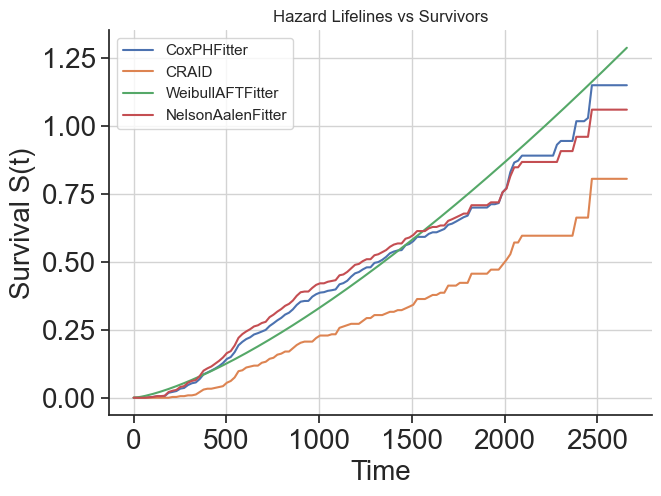

In [ ]:
from lifelines import CoxPHFitter, NelsonAalenFitter, WeibullAFTFitter
import survivors.datasets as ds
from survivors.tree import CRAID

X, y, features, categ, sch_nan = ds.load_gbsg_dataset()

cr = CRAID(criterion='wilcoxon', depth=2, min_samples_leaf=0.1,
           signif=0.05, categ=categ, leaf_model="base")

m_sa1 = SAWrapSA(CoxPHFitter()).fit(X, y)
m_sa2 = SAWrapSA(cr).fit(X, y)
m_sa3 = SAWrapSA(WeibullAFTFitter()).fit(X,y)
m_sa4 = SAWrapSA(NelsonAalenFitter()).fit(X,y)

plot_many([m_sa1, m_sa2, m_sa3, m_sa4], X, sample=0, mode="hazard", title="Hazard Lifelines vs Survivors")

fitted: 10 models.


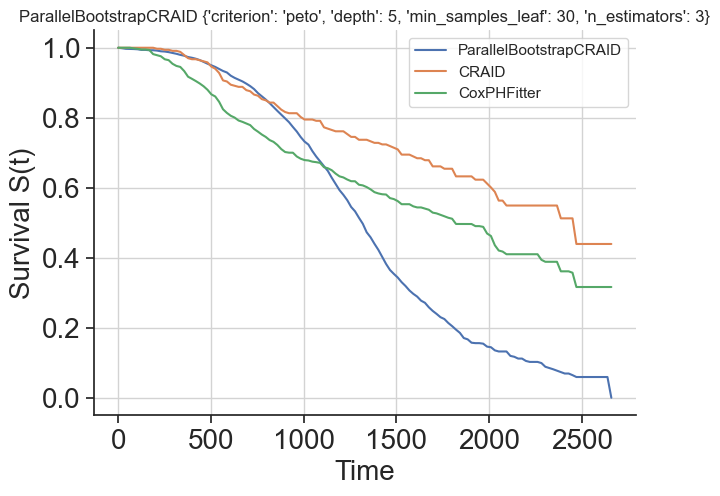

fitted: 10 models.


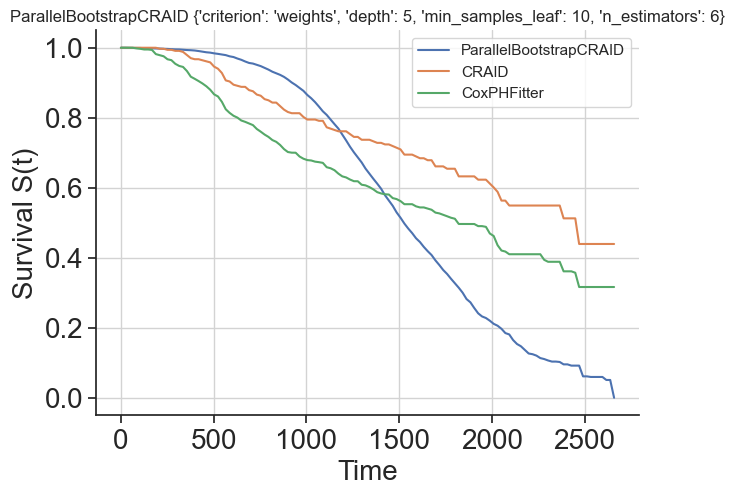

fitted: 10 models.


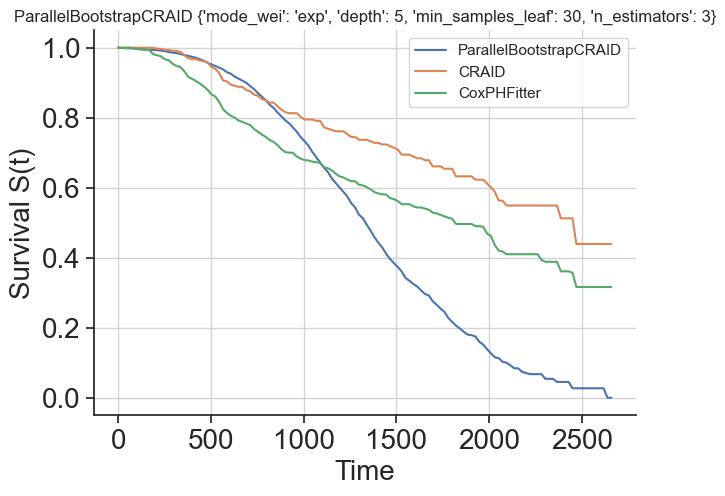

fitted: 10 models.


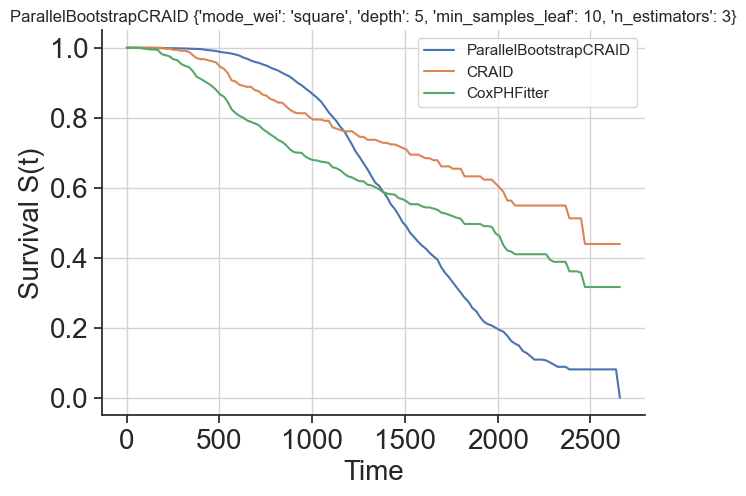

In [ ]:
from survivors.ensemble import ParallelBootstrapCRAID, BoostingCRAID
from survivors.external import CoxPH
from lifelines import CoxPHFitter

param_grid = [
    ({"criterion": "peto", "depth": 5, "min_samples_leaf": 30, "n_estimators": 3}, 0.19),
    ({"criterion": "weights", "depth": 5, "min_samples_leaf": 10, "n_estimators": 6}, 0.175),
    ({"mode_wei": "exp", "depth": 5, "min_samples_leaf": 30, "n_estimators": 3}, 0.186),
    ({"mode_wei": "square", "depth": 5, "min_samples_leaf": 10, "n_estimators": 3}, 0.15),
]

X, y, features, categ, sch_nan = ds.load_gbsg_dataset()

cr = CRAID(criterion='wilcoxon', depth=2, min_samples_leaf=0.1,
           signif=0.05, categ=categ, leaf_model="base")

for params, ibs_thres in param_grid:
    PBC = ParallelBootstrapCRAID(**params)

    m_sa1 = SAWrapSA(PBC).fit(X, y)
    m_sa3 = SAWrapSA(CoxPHFitter()).fit(X, y)
    m_sa2 = SAWrapSA(cr).fit(X, y)
    m_sa4 = SAWrapSA(BoostingCRAID()).fit(X, y)

    plot_many([m_sa1, m_sa2, m_sa3], X, sample=0,
              title=f"ParallelBootstrapCRAID {params}")


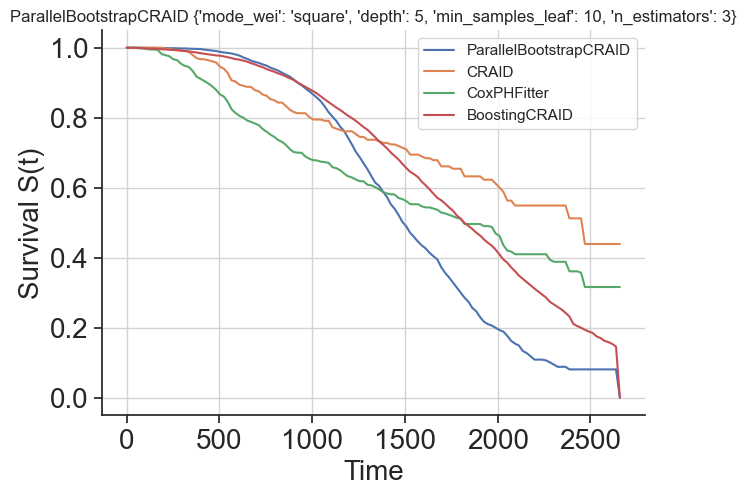

In [ ]:
 plot_many([m_sa1, m_sa2, m_sa3, m_sa4], X, sample=0,
              title=f"ParallelBootstrapCRAID {params}")

In [ ]:
X_tr, X_tst, y_tr, y_tst = train_test_split(X, y, test_size=0.3)

bins = get_bins(y_tr, n_bins=m_sa1.times)

for params, ibs_thres in param_grid:
    print("\n=== ParallelBootstrapCRAID params:", params, "===\n")

    PBC = ParallelBootstrapCRAID(**params)

    m_sa1 = SAWrapSA(PBC).fit(X_tr, y_tr)
    m_sa2 = SAWrapSA(cr).fit(X_tr, y_tr)
    m_sa3 = SAWrapSA(CoxPHFitter()).fit(X_tr, y_tr)

    res_pbc = eval_survival_model(m_sa1, X_tr, y_tr, X_tst, y_tst, bins)
    print("ParallelBootstrapCRAID:")
    print_metrics(res_pbc)



=== ParallelBootstrapCRAID params: {'criterion': 'peto', 'depth': 5, 'min_samples_leaf': 30, 'n_estimators': 3} ===

ParallelBootstrapCRAID:
c_index     : 0.5000
ibs_remain  : 0.1659
auprc       : 0.6645

=== ParallelBootstrapCRAID params: {'criterion': 'weights', 'depth': 5, 'min_samples_leaf': 10, 'n_estimators': 6} ===

ParallelBootstrapCRAID:
c_index     : 0.4736
ibs_remain  : 0.1702
auprc       : 0.6632

=== ParallelBootstrapCRAID params: {'mode_wei': 'exp', 'depth': 5, 'min_samples_leaf': 30, 'n_estimators': 3} ===

ParallelBootstrapCRAID:
c_index     : 0.5048
ibs_remain  : 0.1767
auprc       : 0.6632

=== ParallelBootstrapCRAID params: {'mode_wei': 'square', 'depth': 5, 'min_samples_leaf': 10, 'n_estimators': 3} ===

ParallelBootstrapCRAID:
c_index     : 0.4697
ibs_remain  : 0.1716
auprc       : 0.6638


In [ ]:
X_tr, X_tst, y_tr, y_tst = train_test_split(X, y, test_size=0.3)

bins = cnt.get_bins(time=y_tr['time'], cens=y_tr['cens'])

for params, ibs_thres in param_grid:
    print("\n=== ParallelBootstrapCRAID params:", params, "===\n")

    PBC = ParallelBootstrapCRAID(**params)

    m_sa1 = SAWrapSA(PBC).fit(X_tr, y_tr)
    m_sa2 = SAWrapSA(cr).fit(X_tr, y_tr)
    m_sa3 = SAWrapSA(CoxPHFitter()).fit(X_tr, y_tr)

    res_pbc = eval_survival_model(m_sa1, X_tr, y_tr, X_tst, y_tst, bins)
    print("ParallelBootstrapCRAID:")
    print_metrics(res_pbc)


=== ParallelBootstrapCRAID params: {'criterion': 'peto', 'depth': 5, 'min_samples_leaf': 30, 'n_estimators': 3} ===

ParallelBootstrapCRAID:
c_index     : 0.5049
ibs_remain  : 0.1815
auprc       : 0.6667

=== ParallelBootstrapCRAID params: {'criterion': 'weights', 'depth': 5, 'min_samples_leaf': 10, 'n_estimators': 6} ===

ParallelBootstrapCRAID:
c_index     : 0.4736
ibs_remain  : 0.1859
auprc       : 0.6657

=== ParallelBootstrapCRAID params: {'mode_wei': 'exp', 'depth': 5, 'min_samples_leaf': 30, 'n_estimators': 3} ===

ParallelBootstrapCRAID:
c_index     : 0.5055
ibs_remain  : 0.1915
auprc       : 0.6658

=== ParallelBootstrapCRAID params: {'mode_wei': 'square', 'depth': 5, 'min_samples_leaf': 10, 'n_estimators': 3} ===

ParallelBootstrapCRAID:
c_index     : 0.4674
ibs_remain  : 0.1875
auprc       : 0.6661
